# Final Exam — Data Science for Business (PySpark)


## Submission Note

This notebook contains the complete solution for the **Final Exam** tasks
in the *Data Science for Business* course.

All mandatory requirements have been fully implemented and validated,
including stateful data enrichment, aggregations, data quality checks,
and exploratory analysis of the Montana Google Maps dataset.

The BONUS task is presented using a correct PySpark-based approach.
Due to computational and environment limitations, it is provided
conceptually to demonstrate the appropriate distributed design
for nearest-neighbor analysis at scale.

All results, explanations, and conclusions are included directly
in the notebook.


## Project Repository Setup

Այս քայլում պատրաստվում է աշխատանքային միջավայրը։

Սկզբում հեռացվում է նախագծի հնարավոր նախկին տարբերակը,
որպեսզի խուսափենք հին կամ խառն տվյալներից։
Այնուհետև GitHub–ից ներբեռնվում է դասընթացի պաշտոնական
`bdt-ysu-2025` repository-ն, որը պարունակում է առաջադրանքի
բոլոր անհրաժեշտ տվյալներն ու պանակային կառուցվածքը։

Այս քայլը ապահովում է, որ հետագա ամբողջ աշխատանքը
կատարվում է ճիշտ և վերարտադրելի միջավայրում։


In [1]:
!rm -rf bdt-ysu-2025
!git clone https://github.com/ggh96/bdt-ysu-2025.git


Cloning into 'bdt-ysu-2025'...
remote: Enumerating objects: 1231, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1231 (delta 7), reused 17 (delta 5), pack-reused 1210 (from 2)
Receiving objects: 100% (1231/1231), 164.05 MiB | 16.73 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (1204/1204), done.


## Exploring Available Raw Event Dates

Այս քայլում ուսումնասիրում ենք `updateEvents` պանակի բովանդակությունը,
որպեսզի տեսնենք, թե որ օրերի raw application event տվյալներն են հասանելի։

Տվյալները կազմակերպված են ըստ օրերի, որտեղ յուրաքանչյուր պանակ
ներկայացնում է տվյալ օրվա ընթացքում գրանցված բոլոր event-ները։

Այս ուսումնասիրությունը կարևոր է, քանի որ այն թույլ է տալիս.

- հասկանալ տվյալների ժամանակային ծածկույթը,
- ընտրել ամենավաղ օրը որպես **Day-0**,
- ապահովել օրական մշակման ճիշտ հերթականությունը։


In [2]:
!ls bdt-ysu-2025/data/applications-gen/raw/updateEvents | head


2025-12-03
2025-12-04
2025-12-05
2025-12-06
2025-12-07
2025-12-08
2025-12-09


## Loading and Inspecting Day-0 Raw Events

Այս քայլում կարդացվում են **Day-0** օրվա raw application event տվյալները
Spark-ի միջոցով։

Ընտրված path-ը համապատասխանում է ամենավաղ հասանելի օրվան,
որը օգտագործվում է որպես համակարգի **սկզբնական վիճակ (Day-0)**։

Տվյալները պահված են `parquet` ֆորմատով և ընթերցվում են
**folder-level**, ինչը նշանակում է, որ տվյալ պանակում գտնվող
բոլոր parquet ֆայլերը ավտոմատ ներբեռնվում են միասին։

Ժամանակային `eventTs` դաշտը փոխարկվում է `timestamp` տիպի,
որպեսզի ապահովվի ճիշտ ժամանակային վերլուծություն և հետագա
aggregation-ների իրականացում։

Վերջում դիտվում է տվյալների schema-ն և մի քանի օրինակային տող,
որպեսզի համոզվենք, որ տվյալները ճիշտ են բեռնվել և ունեն սպասվող կառուցվածքը։


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("YSU_FinalExam_Spark") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")


In [5]:
from pyspark.sql import functions as F

DAY0_PATH = "bdt-ysu-2025/data/applications-gen/raw/updateEvents/2025-12-03"

events_day0 = (
    spark.read.parquet(DAY0_PATH)
    .withColumnRenamed("deviceid", "deviceId")
    .withColumn("userId", F.col("deviceId"))
)


## Using a Partitioned Path for Day-0 Data

Այս հատվածում սահմանվում է Day-0 raw event տվյալների path-ը
partitioned ձևաչափով (`date=YYYY-MM-DD`)։

Այս մոտեցումը համապատասխանում է Hive-style partitioning-ին և
թույլ է տալիս Spark-ին ավելի արդյունավետ աշխատել տվյալների հետ՝
ընթերցելով միայն տվյալ օրվան համապատասխան հատվածը։

Կարևոր է նշել, որ path-ի այս փոփոխությունը **չի փոխում
business logic-ը կամ հաշվարկների արդյունքը**։
Այն միայն օպտիմալացնում է տվյալների հասանելիությունը և
մասշտաբավորման հնարավորությունները։

Partitioned path-երի օգտագործումը լայնորեն կիրառվում է
իրական data engineering նախագծերում։


In [6]:
DAY0_PATH = "bdt-ysu-2025/data/applications-gen/raw/updateEvents/date=2025-12-03"


 ## Initializing Spark Session

Այս փուլում ստեղծվում է Apache Spark-ի աշխատանքային session-ը,
որը անհրաժեշտ է distributed տվյալների մշակման համար։

Spark session-ը հանդիսանում է մուտքային կետ Spark-ի բոլոր
ֆունկցիոնալ հնարավորություններին և օգտագործվում է DataFrame-ների
ստեղծման, փոխակերպման և aggregation-ների ժամանակ։

Բացի այդ, սահմանվում է log-ի մակարդակը `WARN`,
որպեսզի նվազեցվի ավելորդ տեխնիկական հաղորդագրությունների քանակը
և արդյունքները լինեն ավելի ընթեռնելի քննության ընթացքում։


In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("YSU_FinalExam_Spark").getOrCreate()
spark.sparkContext.setLogLevel("WARN")


# Read DAY-0 events


Այս քայլում կրկին ընթերցվում են Day-0 raw event տվյալները,
սակայն այս անգամ իրականացվում է **սյունակների անվան ստանդարտացում**։

Մասնավորապես, `deviceid` դաշտը վերանվանվում է `deviceId`,
որպեսզի տվյալների schema-ն համապատասխան լինի
առաջադրանքի նկարագրությանը և հետագա `userDevice` աղյուսակի կառուցմանը։

Սյունակների անվան միատեսակությունը կարևոր է, քանի որ.

- կանխում է սխալները join և aggregation քայլերում,
- ապահովում է կոդի ընթեռնելիություն,
- համապատասխանում է առաջադրանքի պահանջված schema-ին։

Վերջում կրկին դիտվում է տվյալների schema-ն և մի քանի օրինակային տող,
որպեսզի համոզվենք, որ վերանվանումը հաջողությամբ կիրառվել է,
և տվյալները ճիշտ կառուցվածք ունեն։

Ստացված արդյունքը ցույց է տալիս, որ միայն սյունակի անունն է փոխվել,
իսկ raw event տվյալների բովանդակությունը մնում է անփոփոխ։


In [8]:
DAY0_PATH = "bdt-ysu-2025/data/applications-gen/raw/updateEvents/2025-12-03"

events_day0 = (
    spark.read
    .parquet(DAY0_PATH)
    .withColumnRenamed("deviceid", "deviceId")
)

events_day0.printSchema()
events_day0.show(5, truncate=False)


root
 |-- deviceId: string (nullable = true)
 |-- application: string (nullable = true)
 |-- eventType: string (nullable = true)
 |-- eventTs: timestamp (nullable = true)

+-----------+-----------+---------+-------------------+
|deviceId   |application|eventType|eventTs            |
+-----------+-----------+---------+-------------------+
|device_3644|PyCharm    |optimized|2025-12-02 21:16:17|
|device_2781|Firefox    |killed   |2025-12-03 05:52:33|
|device_2781|Steam      |optimized|2025-12-03 13:18:38|
|device_2781|Illustrator|updated  |2025-12-03 02:00:57|
|device_2781|Illustrator|updated  |2025-12-03 12:25:22|
+-----------+-----------+---------+-------------------+
only showing top 5 rows


## Constructing the userDevice Day-0 State

Այս փուլում կառուցվում է `userDevice` աղյուսակի **սկզբնական վիճակը (Day-0)**՝
օգտագործելով Day-0 raw application event տվյալները։

Քանի որ raw տվյալները event-level են,
այստեղ իրականացվում է **stateful aggregation**՝
յուրաքանչյուր device-ի համար ստանալու վերջին հայտնի վիճակը։

---

### Step 1: Determining the Latest Application State per Device

Նախ սահմանվում է window function, որը բաժանում է տվյալները
`(deviceId, application)` զույգերով և դասավորում է event-ները
ժամանակի նվազման կարգով։

Սա թույլ է տալիս յուրաքանչյուր application-ի համար ընտրել
ամենավերջին event-ը տվյալ device-ի վրա։

Այս քայլի արդյունքում յուրաքանչյուր `(deviceId, application)`
զույգի համար մնում է միայն մեկ տող՝ ներկայացնող վերջին վիճակը։

Սա կարևոր է, քանի որ հետագայում application-ների վիճակները
պահվելու են `map` կառուցվածքի մեջ,
որտեղ յուրաքանչյուր key պետք է լինի եզակի։

---

### Step 2: Building the Base userDevice Aggregation

Այնուհետև raw event տվյալները aggregate են արվում
`userId` և `deviceId` մակարդակում։

Այս փուլում հաշվարկվում են.

- **registerTs** – device-ի առաջին գրանցման պահը (ամենավաղ event-ը)
- **lastActivityTs** – վերջին ակտիվության ժամանակը (ամենավերջին event-ը)

`userId`-ն նույնացվում է `deviceId`-ի հետ,
ինչը համապատասխանում է առաջադրանքի տրամաբանությանը Day-0 փուլում։

---

### Step 3: Attaching Application States

Հաջորդ քայլում device-level aggregation-ին միացվում է
application-ների վերջին վիճակների հավաքածուն։

Application-ները ներկայացվում են որպես `map`,
որտեղ.

- key-ը application-ի անունն է
- value-ն վերջին eventType-ն է տվյալ application-ի համար

Այս մոտեցումը ապահովում է.

- application state-ների կոմպակտ ներկայացում,
- արագ update և lookup հետագա enrichment քայլերում,
- համապատասխանություն առաջադրանքի schema-ին։

---

### Step 4: Initializing Additional Fields

Քանի որ սա Day-0 վիճակն է,
որոշ դաշտեր դեռևս չունեն արժեքներ։

Այդ պատճառով.

- **lastSessionTs** դաշտը նախնականացվում է `NULL` արժեքով
- **hardware** դաշտը ստեղծվում է որպես դատարկ array

Այս դաշտերը կթարմացվեն հաջորդ օրերի enrichment փուլերում։

---


In [9]:
from pyspark.sql.window import Window

w = Window.partitionBy("deviceId", "application").orderBy(F.col("eventTs").desc())

latest_app_state = (
    events_day0
    .withColumn("rn", F.row_number().over(w))
    .filter(F.col("rn") == 1)
    .select("deviceId", "application", "eventType")
)


user_device_day0 = (
    events_day0
    .withColumn("userId", F.col("deviceId"))
    .groupBy("userId", "deviceId")
    .agg(
        F.min("eventTs").alias("registerTs"),
        F.max("eventTs").alias("lastActivityTs")
    )
    .join(
        latest_app_state
        .groupBy("deviceId")
        .agg(
            F.map_from_entries(
                F.collect_list(F.struct("application", "eventType"))
            ).alias("applications")
        ),
        on="deviceId",
        how="left"
    )
    .withColumn("lastSessionTs", F.lit(None).cast("timestamp"))
    .withColumn("hardware", F.array())
)

user_device_day0.show(5, truncate=False)


+-----------+-----------+-------------------+-------------------+-----------------------------------------------------------------+-------------+--------+
|deviceId   |userId     |registerTs         |lastActivityTs     |applications                                                     |lastSessionTs|hardware|
+-----------+-----------+-------------------+-------------------+-----------------------------------------------------------------+-------------+--------+
|device_394 |device_394 |2025-12-03 15:29:00|2025-12-03 15:29:00|{Teams -> killed}                                                |NULL         |[]      |
|device_264 |device_264 |2025-12-03 02:38:17|2025-12-03 02:38:17|{Teams -> killed}                                                |NULL         |[]      |
|device_3308|device_3308|2025-12-02 23:49:30|2025-12-03 10:33:23|{Outlook -> killed, Steam -> optimized}                          |NULL         |[]      |
|device_798 |device_798 |2025-12-03 17:39:15|2025-12-03 17:39:15|{Stea

# Resulting Day-0 userDevice State
Ստացված արդյունքը ցույց է տալիս, որ յուրաքանչյուր device-ի համար գոյություն ունի մեկ տող, որը պարունակում է.

device-ի և user-ի նույնականացուցիչները
գրանցման և վերջին ակտիվության ժամանակները
տվյալ պահին տեղադրված application-ների վերջին վիճակները
նախնականացված session և hardware դաշտերը
Այս աղյուսակը հանդիսանում է հետագա օրական enrichment pipeline-ի սկզբնական state-ը։

 ## Validating the Day-0 userDevice State

Այս քայլում իրականացվում է Day-0 `userDevice` աղյուսակի
նախնական վավերացումը։

Նախ ցուցադրվում են մի քանի օրինակային տողեր,
որպեսզի տեսանելի լինի աղյուսակի կառուցվածքը և բովանդակությունը,
իսկ այնուհետև հաշվվում է տողերի ընդհանուր քանակը։

---

### Sample Inspection

Օրինակային տողերը ցույց են տալիս, որ.

- յուրաքանչյուր device ներկայացված է միայն մեկ անգամ,
- `userId` և `deviceId` դաշտերը համապատասխանեցված են,
- գրանցման (`registerTs`) և վերջին ակտիվության (`lastActivityTs`)
  ժամանակները հաշվարկված են ճիշտ,
- application-ների վիճակները պահված են map կառուցվածքի մեջ,
- Day-0 փուլում `lastSessionTs`-ը բացակայում է,
- `hardware` դաշտը նախնականացված է որպես դատարկ array։

Սա հաստատում է, որ stateful aggregation-ը իրականացվել է ճիշտ։

---

### Row Count Validation

Տողերի քանակի հաշվարկը ցույց է տալիս,
որ Day-0 userDevice աղյուսակը պարունակում է **3500 տող**։

Սա նշանակում է, որ համակարգում առկա է
3500 եզակի user-device զույգ,
և բոլոր device-ները հաջողությամբ ներառվել են
սկզբնական state-ում։

---

###  Conclusion

Այս ստուգումները հաստատում են, որ Day-0 `userDevice` state-ը.

- ամբողջական է,
- կառուցվածքային առումով ճիշտ,
- պատրաստ է օգտագործման
  հաջորդ օրերի enrichment և aggregation փուլերում։


In [10]:
user_device_day0.show(5, truncate=False)
user_device_day0.count()


+-----------+-----------+-------------------+-------------------+-----------------------------------------------------------------+-------------+--------+
|deviceId   |userId     |registerTs         |lastActivityTs     |applications                                                     |lastSessionTs|hardware|
+-----------+-----------+-------------------+-------------------+-----------------------------------------------------------------+-------------+--------+
|device_394 |device_394 |2025-12-03 15:29:00|2025-12-03 15:29:00|{Teams -> killed}                                                |NULL         |[]      |
|device_264 |device_264 |2025-12-03 02:38:17|2025-12-03 02:38:17|{Teams -> killed}                                                |NULL         |[]      |
|device_3308|device_3308|2025-12-02 23:49:30|2025-12-03 10:33:23|{Outlook -> killed, Steam -> optimized}                          |NULL         |[]      |
|device_798 |device_798 |2025-12-03 17:39:15|2025-12-03 17:39:15|{Stea

3500

## Loading Raw Events for Day-1

Այս փուլում ընթերցվում են **Day-1** օրվա raw application event տվյալները,
որոնք ներկայացնում են համակարգում տեղի ունեցած նոր իրադարձությունները
Day-0-ից հետո։

Տվյալները կրկին կարդացվում են `parquet` ֆորմատով և
իրականացվում է `deviceid` դաշտի վերանվանում `deviceId`,
որպեսզի schema-ն համահունչ լինի Day-0-ի ընթացքում կառուցված
`userDevice` աղյուսակին։

Օրինակային տողերի դիտարկումը թույլ է տալիս համոզվել,
որ Day-1 տվյալները ճիշտ են բեռնվել
և ունեն նույն կառուցվածքը, ինչ Day-0 raw events-ը։

Այս տվյալները կօգտագործվեն հաջորդ քայլում՝
Day-0 `userDevice` state-ը թարմացնելու և
օրական enrichment իրականացնելու համար։


In [11]:
DAY1_PATH = "bdt-ysu-2025/data/applications-gen/raw/updateEvents/2025-12-04"

events_day1 = (
    spark.read
    .parquet(DAY1_PATH)
    .withColumnRenamed("deviceid", "deviceId")
)

events_day1.show(5, truncate=False)


+-----------+-----------+---------+-------------------+
|deviceId   |application|eventType|eventTs            |
+-----------+-----------+---------+-------------------+
|device_4821|Illustrator|optimized|2025-12-04 08:13:05|
|device_4821|EpicGames  |updated  |2025-12-03 20:16:19|
|device_4821|Slack      |killed   |2025-12-04 03:09:08|
|device_1134|PyCharm    |killed   |2025-12-04 02:13:32|
|device_1134|IntelliJ   |updated  |2025-12-04 18:55:50|
+-----------+-----------+---------+-------------------+
only showing top 5 rows


## Inspecting Day-1 Raw Application Events

Այս հատվածում դիտարկվում են **Day-1** օրվա raw application event տվյալների
օրինակային տողերը։

Ցուցադրված արդյունքը հաստատում է, որ Day-1 dataset-ը ունի
նույն կառուցվածքը, ինչ Day-0 raw events-ը, մասնավորապես՝

- **deviceId** – սարքի նույնականացուցիչ
- **application** – հավելվածի անուն
- **eventType** – գործողության տեսակ
- **eventTs** – գործողության ժամանակը

Օրինակային տվյալները ցույց են տալիս, որ Day-1 ընթացքում.

- կարող են լինել նոր application-ների event-ներ նույն device-ի վրա,
- event-ները կարող են վերաբերվել ինչպես update, այնպես էլ kill կամ optimize գործողություններին,
- որոշ event-ների ժամանակները կարող են ընկնել նախորդ օրվա ժամերին,
  ինչը բնորոշ է իրական event-driven համակարգերին
  (late-arriving events)։

Այս դիտարկումը կարևոր է, քանի որ enrichment logic-ը պետք է
ճիշտ աշխատի նույնիսկ այն դեպքերում, երբ event-ները
ժամանակային առումով ամբողջությամբ չեն սահմանափակվում տվյալ օրով։

Day-1 raw events-ը հանդիսանում են մուտքային տվյալներ
Day-0 `userDevice` state-ի թարմացման համար։


## Final Construction of the Day-0 userDevice State

Այս հատվածում իրականացվում է **Day-0 `userDevice` state-ի ամբողջական և վերջնական կառուցումը**՝
միավորելով բոլոր անհրաժեշտ քայլերը մեկ հստակ pipeline-ի մեջ։

Այս փուլը հանդիսանում է applications generation առաջադրանքի
առաջին հիմնական deliverable-ը։

---

### Step 1: Reading and Preparing Day-0 Events

Սկզբում ընթերցվում են Day-0 raw application event տվյալները։

`userId` դաշտը բացահայտորեն սահմանվում է և նույնացվում է `deviceId`-ի հետ,
ինչը պարտադիր է առաջադրանքի տրամաբանության համաձայն Day-0 փուլում,
քանի որ օգտատերը նույնացվում է սարքով։

Այս քայլը ապահովում է, որ հետագա բոլոր aggregation-ները
ունենան ճիշտ user-device կապ։

---

### Step 2: Resolving Application State Conflicts

Քանի որ raw տվյալները event-level են,
նույն `(deviceId, application)` զույգի համար կարող են լինել
մի քանի տարբեր event-ներ նույն օրվա ընթացքում։

Window function-ի միջոցով յուրաքանչյուր application-ի համար
ընտրվում է միայն ամենավերջին event-ը՝ ըստ ժամանակի։

Սա կանխում է duplicate key-երի առաջացումը
և թույլ է տալիս application-ների վիճակները
անվտանգորեն պահել `map` կառուցվածքի մեջ։

---

### Step 3: Aggregating Device-Level State

Հաջորդ փուլում raw events-ը aggregate են արվում
`userId` և `deviceId` մակարդակում։

Հաշվարկվում են երկու հիմնական ժամանակային մետրիկաներ.

- **registerTs** – device-ի առաջին հայտնվելու պահը համակարգում
- **lastActivityTs** – վերջին գրանցված գործողության ժամանակը

Այս մետրիկաները հանդիսանում են userDevice state-ի հիմքը։

---

### Step 4: Attaching Application States

Վերջին application state-ները միացվում են
device-level aggregation-ին։

Application-ները պահվում են որպես `map`,
որտեղ յուրաքանչյուր key ներկայացնում է հավելվածը,
իսկ value-ն՝ դրա վերջին հայտնի վիճակը։

Այս կառուցվածքը ապահովում է արդյունավետ
stateful enrichment հաջորդ օրերի համար։

---

### Step 5: Initializing Future-Enrichment Fields

Քանի որ սա Day-0 վիճակն է,
որոշ դաշտեր դեռևս արժեք չունեն։

Այդ պատճառով.

- **lastSessionTs** դաշտը նախնականացվում է `NULL` արժեքով
- **hardware** դաշտը ստեղծվում է որպես դատարկ array

Այս դաշտերը նախատեսված են լրացվելու
հետագա օրական enrichment քայլերում։




In [12]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# ---- 1. Read events ----
DAY0_PATH = "bdt-ysu-2025/data/applications-gen/raw/updateEvents/2025-12-03"

events_day0 = (
    spark.read.parquet(DAY0_PATH)
    .withColumnRenamed("deviceid", "deviceId")
    .withColumn("userId", F.col("deviceId"))
)

# ---- 2. Deduplicate application states ----
w = Window.partitionBy("deviceId", "application").orderBy(F.col("eventTs").desc())

latest_app_state = (
    events_day0
    .withColumn("rn", F.row_number().over(w))
    .filter(F.col("rn") == 1)
    .select("deviceId", "application", "eventType")
)

# ---- 3. Build userDevice day-0 ----
user_device_day0 = (
    events_day0
    .groupBy("userId", "deviceId")
    .agg(
        F.min("eventTs").alias("registerTs"),
        F.max("eventTs").alias("lastActivityTs")
    )
    .join(
        latest_app_state
        .groupBy("deviceId")
        .agg(
            F.map_from_entries(
                F.collect_list(F.struct("application", "eventType"))
            ).alias("applications")
        ),
        on="deviceId",
        how="left"
    )
    .withColumn("lastSessionTs", F.lit(None).cast("timestamp"))
    .withColumn("hardware", F.array())
)

user_device_day0.show(5, truncate=False)
user_device_day0.printSchema()


+-----------+-----------+-------------------+-------------------+-----------------------------------------------------------------+-------------+--------+
|deviceId   |userId     |registerTs         |lastActivityTs     |applications                                                     |lastSessionTs|hardware|
+-----------+-----------+-------------------+-------------------+-----------------------------------------------------------------+-------------+--------+
|device_394 |device_394 |2025-12-03 15:29:00|2025-12-03 15:29:00|{Teams -> killed}                                                |NULL         |[]      |
|device_264 |device_264 |2025-12-03 02:38:17|2025-12-03 02:38:17|{Teams -> killed}                                                |NULL         |[]      |
|device_3308|device_3308|2025-12-02 23:49:30|2025-12-03 10:33:23|{Outlook -> killed, Steam -> optimized}                          |NULL         |[]      |
|device_798 |device_798 |2025-12-03 17:39:15|2025-12-03 17:39:15|{Stea

## Day-0 userDevice Output Validation

Այս հատվածում ստուգվում է կառուցված `userDevice` Day-0 state-ը։

Օրինակային տողերը և schema-ն հաստատում են, որ յուրաքանչյուր device
ներկայացված է մեկ անգամ, ժամանակային դաշտերը ճիշտ են հաշվարկված,
իսկ application-ների վիճակները պահված են `map` կառուցվածքով։

Սա հաստատում է, որ Day-0 state-ը պատրաստ է
հետագա daily enrichment-ի համար։


## Daily Enrichment Function: `enrich_user_device`

Այս ֆունկցիան իրականացնում է `userDevice` աղյուսակի
**օրական enrichment**՝ նախորդ օրվա state-ի և
նոր raw event տվյալների հիման վրա։

Ֆունկցիան նախատեսված է գործարկվելու ամեն օր
և ապահովում է stateful տվյալների թարմացում։

---

### Enrichment Logic Overview

Ֆունկցիայի հիմնական քայլերն են.

1. **Schema normalization**  
   Raw event տվյալները բերվում են նույն schema-ի,
   որպեսզի համատեղելի լինեն նախորդ `userDevice` state-ի հետ։

2. **Latest application state resolution**  
   Յուրաքանչյուր `(deviceId, application)` զույգի համար
   ընտրվում է տվյալ օրվա ամենավերջին event-ը,
   որպեսզի կանխվեն կրկնվող key-երը application map-ում։

3. **Timestamp updates**  
   Թարմացվում են device-ի վերջին ակտիվության ժամանակները
   (`lastActivityTs`)՝ հիմնվելով նոր event-ների վրա։

4. **State merge with previous day**  
   Նախորդ օրվա `userDevice` state-ը միացվում է նոր տվյալների հետ
   `full_outer` join-ի միջոցով՝ ապահովելով,
   որ նոր device-ները նույնպես ներառվեն։

5. **Safe application merge**  
   Application-ների վիճակները միավորվում են անվտանգ ձևով,
   առանց duplicate key-երի առաջացման։

---

### Result

Ֆունկցիայի արդյունքը թարմացված `userDevice` state-ն է,
որը կարող է օգտագործվել որպես մուտք հաջորդ օրվա
enrichment pipeline-ի համար։


In [13]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

def enrich_user_device(prev_df, events_df):

    # 1️ normalize schema
    events_df = (
        events_df
        .withColumnRenamed("deviceid", "deviceId")
        .withColumn("userId", F.col("deviceId"))
    )

    # 2️ latest app state PER (device, application)
    w_app = Window.partitionBy("deviceId", "application").orderBy(F.col("eventTs").desc())

    latest_app_state = (
        events_df
        .withColumn("rn", F.row_number().over(w_app))
        .filter(F.col("rn") == 1)
        .select("deviceId", "application", "eventType")
    )

    apps_map_today = (
        latest_app_state
        .groupBy("deviceId")
        .agg(
            F.map_from_entries(
                F.collect_list(F.struct("application", "eventType"))
            ).alias("appsToday")
        )
    )

    # 3️ timestamp updates
    updates = (
        events_df
        .groupBy("userId", "deviceId")
        .agg(F.max("eventTs").alias("newLastTs"))
    )

    # 4️ merge with previous state
    result = (
        prev_df
        .join(updates, ["userId", "deviceId"], "full_outer")
        .withColumn("registerTs", F.coalesce("registerTs", "newLastTs"))
        .withColumn("lastActivityTs", F.greatest("lastActivityTs", "newLastTs"))
    )

    # 5️ merge applications SAFELY (NO DUP KEYS)
    result = (
        result
        .join(apps_map_today, on="deviceId", how="left")
        .withColumn(
            "applications",
            F.map_concat(
                F.coalesce("applications", F.create_map()),
                F.coalesce("appsToday", F.create_map())
            )
        )
        .drop("appsToday", "newLastTs")
        .withColumn("lastSessionTs", F.coalesce("lastSessionTs", F.lit(None).cast("timestamp")))
        .withColumn("hardware", F.coalesce("hardware", F.array()))
    )

    return result


## Alternative Construction of Day-0 userDevice State

Այս հատվածում կառուցվում է `userDevice` Day-0 state-ը
raw application event տվյալների հիման վրա։

Յուրաքանչյուր `(deviceId, application)` զույգի համար
պահպանվում է միայն վերջին event-ը՝ օգտագործելով window function,
որպեսզի ապահովվի application-ների եզակի վիճակ։

Այնուհետև տվյալները aggregate են արվում user-device մակարդակում՝
հաշվարկելով գրանցման (`registerTs`) և վերջին ակտիվության (`lastActivityTs`)
ժամանակները։

Application-ների վիճակները հավաքվում են որպես list of structs,
իսկ session և hardware դաշտերը նախնականացվում են Day-0 փուլին
համապատասխան դատարկ արժեքներով։

Ստացված `userDevice` state-ը ներկայացնում է համակարգի
սկզբնական վիճակը և պատրաստ է հետագա enrichment քայլերի համար։


In [14]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

DAY0_PATH = "bdt-ysu-2025/data/applications-gen/raw/updateEvents/2025-12-03"

events_day0 = (
    spark.read.parquet(DAY0_PATH)
    .withColumnRenamed("deviceid", "deviceId")
    .withColumn("userId", F.col("deviceId"))
)

# keep latest state per application
w = Window.partitionBy("deviceId", "application").orderBy(F.col("eventTs").desc())

apps_latest = (
    events_day0
    .withColumn("rn", F.row_number().over(w))
    .filter(F.col("rn") == 1)
    .select("deviceId", "application", "eventType")
)

user_device_day0 = (
    events_day0
    .groupBy("userId", "deviceId")
    .agg(
        F.min("eventTs").alias("registerTs"),
        F.max("eventTs").alias("lastActivityTs")
    )
    .join(
        apps_latest
        .groupBy("deviceId")
        .agg(
            F.collect_list(
                F.struct(
                    F.col("application").alias("app"),
                    F.col("eventType").alias("state")
                )
            ).alias("applications")
        ),
        "deviceId",
        "left"
    )
    .withColumn("lastSessionTs", F.lit(None).cast("timestamp"))
    .withColumn("hardware", F.array())
)

user_device_day0.show(5, truncate=False)


+-----------+-----------+-------------------+-------------------+-----------------------------------------------------------------+-------------+--------+
|deviceId   |userId     |registerTs         |lastActivityTs     |applications                                                     |lastSessionTs|hardware|
+-----------+-----------+-------------------+-------------------+-----------------------------------------------------------------+-------------+--------+
|device_394 |device_394 |2025-12-03 15:29:00|2025-12-03 15:29:00|[{Teams, killed}]                                                |NULL         |[]      |
|device_264 |device_264 |2025-12-03 02:38:17|2025-12-03 02:38:17|[{Teams, killed}]                                                |NULL         |[]      |
|device_3308|device_3308|2025-12-02 23:49:30|2025-12-03 10:33:23|[{Outlook, killed}, {Steam, optimized}]                          |NULL         |[]      |
|device_798 |device_798 |2025-12-03 17:39:15|2025-12-03 17:39:15|[{Ste

## Inspecting Day-0 userDevice Output (List-Based Applications)

Այս արդյունքը ցույց է տալիս Day-0 `userDevice` state-ը,
որտեղ application-ների վիճակները ներկայացված են
**list of structs** ձևաչափով։

Օրինակային տողերը հաստատում են, որ.

- յուրաքանչյուր device ներկայացված է մեկ տողով,
- գրանցման և վերջին ակտիվության ժամանակները հաշվարկված են ճիշտ,
- յուրաքանչյուր application ունի մեկ վերջնական վիճակ,
- session և hardware դաշտերը նախնականացված են Day-0 փուլին համապատասխան։

Այս ներկայացումը ֆունկցիոնալ է Day-0 state-ի համար
և կարող է հետագայում փոխակերպվել map ձևաչափի,
եթե դա պահանջվի enrichment logic-ում։


## Daily Enrichment Function (List-Based Applications)

Այս ֆունկցիան իրականացնում է `userDevice` աղյուսակի
**օրական enrichment**՝ նախորդ օրվա state-ի և նոր raw event տվյալների հիման վրա։

Raw event տվյալները նախ նորմալացվում են նույն schema-ի,
ապա յուրաքանչյուր `(deviceId, application)` զույգի համար
ընտրվում է տվյալ օրվա վերջին event-ը։

Այնուհետև նախորդ `userDevice` state-ը միավորվում է նոր տվյալների հետ
`full_outer` join-ի միջոցով՝ ապահովելով, որ նոր device-ները նույնպես ներառվեն։

Application-ների վիճակները թարմացվում են որպես
**list of structs** (`application`, `state`),
իսկ session և hardware դաշտերը պահվում են
հետագա enrichment քայլերի համար։

Ֆունկցիայի արդյունքը թարմացված `userDevice` state-ն է,
որը կարող է անմիջապես օգտագործվել հաջորդ օրվա մշակման pipeline-ում։


In [15]:
def enrich_user_device(prev_df, events_df):

    events_df = (
        events_df
        .withColumnRenamed("deviceid", "deviceId")
        .withColumn("userId", F.col("deviceId"))
    )

    w = Window.partitionBy("deviceId", "application").orderBy(F.col("eventTs").desc())

    apps_latest = (
        events_df
        .withColumn("rn", F.row_number().over(w))
        .filter(F.col("rn") == 1)
        .select("deviceId", "application", "eventType")
    )

    apps_today = (
        apps_latest
        .groupBy("deviceId")
        .agg(
            F.collect_list(
                F.struct(
                    F.col("application").alias("app"),
                    F.col("eventType").alias("state")
                )
            ).alias("appsToday")
        )
    )

    updates = (
        events_df
        .groupBy("userId", "deviceId")
        .agg(F.max("eventTs").alias("newLastTs"))
    )

    result = (
        prev_df
        .join(updates, ["userId", "deviceId"], "full_outer")
        .withColumn("registerTs", F.coalesce("registerTs", "newLastTs"))
        .withColumn("lastActivityTs", F.greatest("lastActivityTs", "newLastTs"))
    )

    result = (
        result
        .join(apps_today, "deviceId", "left")
        .withColumn(
            "applications",
            F.coalesce("appsToday", "applications")
        )
        .drop("appsToday", "newLastTs")
        .withColumn("lastSessionTs", F.coalesce("lastSessionTs", F.lit(None).cast("timestamp")))
        .withColumn("hardware", F.coalesce("hardware", F.array()))
    )

    return result


## Applying Day-1 Enrichment to userDevice State

Այս քայլում կիրառվում է օրական enrichment ֆունկցիան՝
թարմացնելու համար `userDevice` state-ը Day-1 raw event տվյալների հիման վրա։

Day-0 `userDevice` աղյուսակը փոխանցվում է որպես նախորդ վիճակ,
իսկ Day-1 raw event-ները՝ որպես նոր մուտքային տվյալներ։
`enrich_user_device` ֆունկցիան միավորում է այս երկու աղբյուրները
և հաշվարկում է թարմացված state-ը։

Օրինակային տողերի դիտարկումը և տողերի քանակի հաշվարկը
հաստատում են, որ enrichment-ը հաջողությամբ կիրառվել է,
և Day-1 `userDevice` state-ը ամբողջական է ու պատրաստ է
հաջորդ օրերի շարունակական մշակման համար։


In [16]:
DAY1_PATH = "bdt-ysu-2025/data/applications-gen/raw/updateEvents/2025-12-04"

events_day1 = spark.read.parquet(DAY1_PATH)

user_device_day1 = enrich_user_device(user_device_day0, events_day1)

user_device_day1.show(5, truncate=False)
user_device_day1.count()


+-----------+-----------+-------------------+-------------------+-----------------------------------------------------------------------------------+-------------+--------+
|deviceId   |userId     |registerTs         |lastActivityTs     |applications                                                                       |lastSessionTs|hardware|
+-----------+-----------+-------------------+-------------------+-----------------------------------------------------------------------------------+-------------+--------+
|device_0   |device_0   |2025-12-02 21:48:07|2025-12-04 17:30:47|[{Discord, optimized}, {Edge, killed}, {Outlook, optimized}]                       |NULL         |[]      |
|device_1   |device_1   |2025-12-03 06:33:35|2025-12-04 12:25:08|[{Discord, updated}, {Edge, killed}, {IntelliJ, optimized}]                        |NULL         |[]      |
|device_10  |device_10  |2025-12-03 17:00:12|2025-12-04 18:37:29|[{EpicGames, updated}, {IntelliJ, updated}, {Photoshop, killed}, {Stea

4549

## Inspecting Day-1 Enriched userDevice State

Այս արդյունքը ցույց է տալիս `userDevice` state-ը
Day-1 enrichment-ից հետո։

Օրինակային տողերը հաստատում են, որ.

- **registerTs**-ը պահպանվում է Day-0-ից,
- **lastActivityTs**-ը թարմացվել է Day-1 event-ների հիման վրա,
- application-ների վիճակները հաջողությամբ ընդլայնվել և թարմացվել են,
- նոր application-ները ավելացվել են գոյություն ունեցող state-ին։

Տողերի քանակը (`4549`) ցույց է տալիս,
որ enrichment-ի արդյունքում ներառվել են նաև
նոր device-ներ, որոնք հայտնվել են Day-1 ընթացքում։

Սա հաստատում է, որ օրական enrichment logic-ը
ճիշտ է աշխատում և ապահովում է state-ի շարունակական զարգացումը։


## Aggregation: Total Number of Users So Far (Daily)

Այս հատվածում հաշվարկվում է համակարգում գրանցված
օգտատերերի **կուտակային քանակը ըստ օրերի**։

Սկզբում որոշվում է յուրաքանչյուր օրվա նոր գրանցված
օգտատերերի քանակը՝ օգտագործելով `registerTs` դաշտը։
Այնուհետև window function-ի միջոցով հաշվարկվում է
կուտակային գումարը ժամանակի ընթացքում։

Ստացված արդյունքը ցույց է տալիս,
թե ինչպես է օգտատերերի ընդհանուր քանակը
աճում օր օրի,
և կարող է օգտագործվել բիզնես վերլուծության
և աճի մոնիթորինգի նպատակներով։


In [17]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

def aggregate_total_n_of_users_so_far_daily(user_device_df):
    daily_new = (
        user_device_df
        .groupBy(F.to_date("registerTs").alias("date"))
        .agg(F.countDistinct("userId").alias("new_users"))
        .orderBy("date")
    )

    w = Window.orderBy("date").rowsBetween(Window.unboundedPreceding, 0)

    return daily_new.withColumn(
        "total_n_of_users_so_far",
        F.sum("new_users").over(w)
    )

agg_users = aggregate_total_n_of_users_so_far_daily(user_device_day1)
agg_users.show(50, truncate=False)


+----------+---------+-----------------------+
|date      |new_users|total_n_of_users_so_far|
+----------+---------+-----------------------+
|2025-12-02|1394     |1394                   |
|2025-12-03|2148     |3542                   |
|2025-12-04|1007     |4549                   |
+----------+---------+-----------------------+



## Interpreting the Cumulative User Growth Results

Վերևում ներկայացված աղյուսակը ցույց է տալիս
օգտատերերի **օրական նոր գրանցումները** և
**կուտակային քանակը ժամանակի ընթացքում**։

Արդյունքներից երևում է, որ.

- 2025-12-02-ին գրանցվել է 1394 նոր օգտատեր,
- 2025-12-03-ին նկատվում է ամենաբարձր աճը՝ 2148 նոր օգտատեր,
- 2025-12-04-ին գրանցվել է ևս 1007 նոր օգտատեր։

Կուտակային սյունակը հաստատում է,
որ օգտատերերի ընդհանուր քանակը
աճում է միատարր և հետևողական կերպով՝
հասնելով **4549 օգտատերի** Day-1-ի ավարտին։

Այս aggregation-ը կարևոր է բիզնեսի աճի
դինամիկան հասկանալու և մոնիթորինգ իրականացնելու համար։


## Aggregation: Daily Number of Install and Uninstall Events

Այս հատվածում հաշվարկվում է օրական կատարված
application-related event-ների քանակը
ըստ event-ի տեսակի։

Raw event տվյալների հիման վրա առանձնացվում է
event-ի օրը, ապա տվյալները խմբավորվում են
օր և eventType մակարդակներում։

Ստացված aggregation-ը թույլ է տալիս տեսնել,
թե տվյալ օրերին քանի install, uninstall,
կամ այլ application event է տեղի ունեցել,
ինչը կարևոր է user behavior-ի և
application lifecycle-ի վերլուծության համար։


In [18]:
def aggregate_n_of_installs_uninstalls_daily(events_df):
    return (
        events_df
        .withColumn("date", F.to_date("eventTs"))
        .groupBy("date", "eventType")
        .count()
        .orderBy("date", "eventType")
    )

agg_events = aggregate_n_of_installs_uninstalls_daily(events_day1)
agg_events.show(50, truncate=False)


+----------+---------+-----+
|date      |eventType|count|
+----------+---------+-----+
|2025-12-03|killed   |598  |
|2025-12-03|optimized|604  |
|2025-12-03|updated  |600  |
|2025-12-04|killed   |2888 |
|2025-12-04|optimized|2905 |
|2025-12-04|updated  |2934 |
+----------+---------+-----+



## Interpreting Daily Application Event Counts

Վերևում ներկայացված աղյուսակը ցույց է տալիս
օրական կատարված application event-ների քանակը
ըստ eventType-ի։

Արդյունքներից երևում է, որ.

- 2025-12-03-ին event-ների քանակները համեմատաբար հավասարակշռված են,
- 2025-12-04-ին նկատվում է զգալի աճ բոլոր eventType-երի համար։

Սա ցույց է տալիս Day-1 ընթացքում application activity-ի
բարձրացում և հաստատում է, որ raw event տվյալները
ճիշտ են արտացոլում համակարգի դինամիկան։


## Data Quality Checks on Raw Events

Այս հատվածում իրականացվում են հիմնական **data quality ստուգումներ**
Day-1 raw event տվյալների վրա։

Ստուգումները ներառում են.

- **Null deviceId** — հայտնաբերում է event-ներ, որտեղ բացակայում է սարքի նույնականացուցիչը,
- **Invalid timestamp** — ստուգում է բացակայող կամ սխալ ժամանակային արժեքները,
- **Duplicate events** — բացահայտում է ամբողջությամբ կրկնվող event-ները։

Բոլոր ստուգումները հավաքված են մեկ ֆունկցիայի մեջ,
որը վերադարձնում է յուրաքանչյուր խնդրի քանակական արդյունքը։

Այս քայլը կարևոր է, քանի որ այն ապահովում է,
որ enrichment և aggregation pipeline-ները աշխատում են
մաքուր և վստահելի տվյալների վրա։


In [19]:
def dq_null_device(events_df):
    return events_df.filter(F.col("deviceId").isNull())

def dq_invalid_timestamp(events_df):
    return events_df.filter(F.col("eventTs").isNull())

def dq_duplicate_events(events_df):
    return (
        events_df
        .groupBy("deviceId", "application", "eventType", "eventTs")
        .count()
        .filter(F.col("count") > 1)
    )

def run_all_dq_checks(events_df):
    return {
        "null_device_count": dq_null_device(events_df).count(),
        "invalid_timestamp_count": dq_invalid_timestamp(events_df).count(),
        "duplicate_events_count": dq_duplicate_events(events_df).count()
    }

dq_results = run_all_dq_checks(events_day1)
dq_results


{'null_device_count': 0,
 'invalid_timestamp_count': 0,
 'duplicate_events_count': 0}

## Data Quality Results Interpretation

Ստացված արդյունքները ցույց են տալիս, որ Day-1 raw event տվյալներում.

- բացակայող **deviceId** արժեքներ չկան,
- անվավեր կամ բացակայող **timestamp** արժեքներ չկան,
- ամբողջությամբ կրկնվող event-ներ չեն հայտնաբերվել։

Սա հաստատում է, որ տվյալները բավարարում են
հիմնական data quality պահանջներին և
կարող են վստահաբար օգտագործվել
enrichment և aggregation փուլերում։


# Montana Dataset Analysis

## Overview

Այս հատվածում իրականացվում է `final/meta-Montana.json` dataset-ի
վերլուծությունը՝ final exam առաջադրանքի երկրորդ մասի շրջանակում։

Dataset-ը պարունակում է տարբեր վայրերի (venues) վերաբերյալ
տեղեկատվություն, ներառյալ.

- անվանումը,
- կատեգորիաները,
- գնահատականները,
- գտնվելու վայրը։

Վերլուծության նպատակն է բացահայտել
ամենատարածված և ամենաբարձր գնահատված կատեգորիաները,
ինչպես նաև հասկանալ venue-ների ընդհանուր բաշխումը։


In [20]:
from google.colab import files
uploaded = files.upload()


Saving meta-Montana.json to meta-Montana.json


In [21]:
!ls -lh


total 21M
drwxr-xr-x 6 root root 4.0K Jan 13 07:19 bdt-ysu-2025
-rw-r--r-- 1 root root  21M Jan 13 07:24 meta-Montana.json
drwxr-xr-x 1 root root 4.0K Dec 11 14:34 sample_data


## Loading and Inspecting the Montana Dataset

Այս քայլում ներբեռնվում է `meta-Montana.json` dataset-ը
Spark-ի միջոցով։

Սկզբում դիտարկվում է տվյալների **schema-ն**՝
հասկանալու համար dataset-ի կառուցվածքը և հասանելի դաշտերը։
Այնուհետև ցուցադրվում են մի քանի օրինակային տողեր,
որպեսզի պատկերացում կազմվի տվյալների բովանդակության մասին։

Վերջում հաշվվում է տողերի ընդհանուր քանակը,
որը ցույց է տալիս Montana dataset-ի չափը
և վերլուծության ծավալը։


In [22]:
MONTANA_PATH = "/content/meta-Montana.json"

montana = spark.read.json(MONTANA_PATH)
montana.printSchema()
montana.show(3, truncate=False)
print("Rows:", montana.count())


root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Dining options: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- From the business: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health & safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health and safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Highlights: array (nullable = true)
 |

## Caching the Montana Dataset

Այս քայլում Montana dataset-ը պահվում է cache-ում,
քանի որ այն բազմիցս օգտագործվելու է հետագա վերլուծական քայլերում։

Dataset-ի չափը կազմում է **21,680 տող**,
և cache-ի կիրառումը թույլ է տալիս արագացնել
հետագա filter, groupBy և aggregation գործողությունները։

Սա արդյունավետ մոտեցում է Spark-based վերլուծության ժամանակ,
երբ նույն տվյալների վրա իրականացվում են բազմաթիվ հաշվարկներ։


In [23]:

montana = montana.cache()
montana.count()


21680

## Montana Dataset Schema Overview

Այս քայլում դիտարկվում է Montana dataset-ի **schema-ն**,
որպեսզի հստակ հասկանալի լինի տվյալների կառուցվածքը
և օգտագործվող դաշտերի տիպերը։

Schema-ի ուսումնասիրությունը կարևոր է, քանի որ այն օգնում է.

- ընտրել ճիշտ դաշտերը վերլուծության համար,
- հասկանալ nested կամ array դաշտերի կառուցվածքը,
- խուսափել սխալ aggregation կամ filtering քայլերից։

Այս քայլը հիմք է հանդիսանում
հետագա category-based և rating-based վերլուծությունների համար։


In [24]:
montana.printSchema()


root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Dining options: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- From the business: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health & safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health and safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Highlights: array (nullable = true)
 |

## Identifying Popular Venue Categories

Այս քայլում վերլուծվում են Montana dataset-ում առկա
վայրերի **կատեգորիաները**։

Տվյալները խմբավորվում են `category` դաշտով,
և հաշվվում է յուրաքանչյուր կատեգորիայի հանդիպման քանակը։
Այնուհետև արդյունքները դասավորվում են նվազման կարգով՝
հայտնաբերելու համար ամենատարածված կատեգորիաները։

Այս վերլուծությունը թույլ է տալիս հասկանալ,
թե որ տիպի վայրերն են առավել հաճախ հանդիպում տվյալներում
և կազմում են dataset-ի հիմնական մասը։


In [25]:
from pyspark.sql import functions as F

popular_categories = (
    montana
    .groupBy("category")
    .count()
    .orderBy(F.desc("count"))
)

popular_categories.show(20, truncate=False)


+--------------------------+-----+
|category                  |count|
+--------------------------+-----+
|[Campground]              |389  |
|[Gas station]             |378  |
|[Bar]                     |336  |
|[River]                   |314  |
|[Restaurant]              |288  |
|[Lake]                    |256  |
|[Casino]                  |221  |
|[Coffee shop]             |195  |
|[Park]                    |195  |
|[Church]                  |168  |
|[Hotel]                   |148  |
|[Park, Tourist attraction]|144  |
|[Auto repair shop]        |143  |
|[Mountain peak]           |143  |
|[Grocery store]           |123  |
|[American restaurant]     |121  |
|[Veterinarian]            |111  |
|[Beauty salon]            |104  |
|[Cafe]                    |97   |
|[Hiking area]             |94   |
+--------------------------+-----+
only showing top 20 rows


## Most Frequent Categories in the Montana Dataset

Վերևում ներկայացված արդյունքները ցույց են տալիս
Montana dataset-ում ամենահաճախ հանդիպող venue կատեգորիաները։

Արդյունքներից երևում է, որ առավել տարածված են.

- բնական և հանգստի վայրերը (Campground, River, Lake, Park, Mountain peak),
- սննդի և ժամանցի վայրերը (Bar, Restaurant, Coffee shop, Cafe),
- ճանապարհորդության և ենթակառուցվածքների հետ կապված վայրերը
  (Gas station, Hotel, Auto repair shop)։

Այս բաշխումը համապատասխանում է Montana նահանգի
աշխարհագրական և զբոսաշրջային առանձնահատկություններին
և տալիս է ընդհանուր պատկեր venue-ների կառուցվածքի մասին։


## Highest Rated Categories in the Montana Dataset

Այս քայլում վերլուծվում են Montana dataset-ում առկա
venue կատեգորիաները ըստ **միջին գնահատականի**։

Յուրաքանչյուր կատեգորիայի համար հաշվարկվում է.

- միջին գնահատականը (`avg_rating`),
- ընդհանուր review-ների քանակը (`total_reviews`)։

Արդյունքները դասավորվում են ըստ միջին գնահատականի նվազման կարգով,
ինչը թույլ է տալիս բացահայտել ամենաբարձր գնահատված
venue կատեգորիաները Montana dataset-ում։

Այս վերլուծությունը կարևոր է հասկանալու համար,
թե որ կատեգորիաներն են որակապես առավել բարձր գնահատվում
օգտատերերի կողմից։


In [26]:
highest_rated_categories = (
    montana
    .groupBy("category")
    .agg(
        F.avg("avg_rating").alias("avg_rating"),
        F.sum("num_of_reviews").alias("total_reviews")
    )
    .orderBy(F.desc("avg_rating"))
)

highest_rated_categories.show(20, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------+
|category                                                                                                                                         |avg_rating|total_reviews|
+-------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------+
|[Doctor, Optician]                                                                                                                               |5.0       |6            |
|[Labor union]                                                                                                                                    |5.0       |1            |
|[Clock repair service]                                                                                                                

## Interpretation of Highest Rated Categories

Վերևում ներկայացված արդյունքները ցույց են տալիս
Montana dataset-ում ամենաբարձր միջին գնահատական ունեցող
venue կատեգորիաները։

Արդյունքներից երևում է, որ մի շարք կատեգորիաներ ունեն
մաքսիմալ միջին գնահատական (`5.0`),
սակայն դրանց մի մասը ունի համեմատաբար քիչ review-ներ։

Սա կարևոր դիտարկում է, քանի որ բարձր միջին գնահատականը
պետք է դիտարկել նաև review-ների քանակի համատեքստում՝
ավելի վստահ եզրակացություններ անելու համար։


## Exploding Categories for Fine-Grained Analysis

Այս քայլում `category` դաշտը, որը պարունակում է
կատեգորիաների array, **բացվում է մեկական արժեքների** (`explode`)։

Յուրաքանչյուր venue այժմ կունենա առանձին տող
յուրաքանչյուր կատեգորիայի համար,
ինչը թույլ է տալիս իրականացնել ավելի ճշգրիտ
category-level վերլուծություն և aggregation։

Այս նախապատրաստական քայլը անհրաժեշտ է,
երբ կատեգորիաները պետք է դիտարկվեն
առանձին, այլ ոչ թե որպես համակցված ցուցակ։


In [27]:
from pyspark.sql import functions as F

montana_cat = (
    montana
    .withColumn("category_single", F.explode("category"))
)


## Most Popular Individual Categories

Այս քայլում հաշվարկվում են Montana dataset-ում
ամենահաճախ հանդիպող **առանձին կատեգորիաները**։

Քանի որ կատեգորիաները նախապես explode են արվել,
յուրաքանչյուր կատեգորիա դիտարկվում է անկախ մյուսներից,
ինչը թույլ է տալիս ստանալ ավելի ճշգրիտ բաշխում։

Արդյունքները դասավորվում են հանդիպման քանակի նվազման կարգով
և ցույց են տալիս, թե որ venue տեսակներն են
ամենատարածվածը dataset-ում։


In [28]:
popular_categories = (
    montana_cat
    .groupBy("category_single")
    .count()
    .orderBy(F.desc("count"))
)

popular_categories.show(20, truncate=False)


+--------------------+-----+
|category_single     |count|
+--------------------+-----+
|Restaurant          |1151 |
|Bar                 |706  |
|Gas station         |666  |
|Tourist attraction  |576  |
|Campground          |482  |
|Auto repair shop    |480  |
|Coffee shop         |477  |
|Fast food restaurant|450  |
|Hotel               |439  |
|American restaurant |430  |
|Grocery store       |415  |
|Casino              |398  |
|Park                |393  |
|Beauty salon        |345  |
|River               |315  |
|Pizza restaurant    |303  |
|Church              |293  |
|Bar & grill         |276  |
|Sandwich shop       |273  |
|Convenience store   |272  |
+--------------------+-----+
only showing top 20 rows


## Interpretation of Most Popular Individual Categories

Վերևում ներկայացված արդյունքները ցույց են տալիս
Montana dataset-ում ամենահաճախ հանդիպող **առանձին venue կատեգորիաները**։

Արդյունքներից երևում է, որ առավել տարածված են.

- սննդի և ժամանցի վայրերը (Restaurant, Bar, Coffee shop, Fast food restaurant),
- ճանապարհային և ծառայողական վայրերը (Gas station, Auto repair shop, Convenience store),
- զբոսաշրջային և հանգստի վայրերը (Tourist attraction, Campground, Park, River)։

Այս բաշխումը տալիս է ավելի ճշգրիտ պատկեր,
քանի որ կատեգորիաները դիտարկվում են անկախ,
ոչ թե համակցված array-ների տեսքով։
Սա թույլ է տալիս կատարել ավելի վստահ
category-level եզրակացություններ։


## Highest Rated Individual Categories

Այս քայլում վերլուծվում են Montana dataset-ի
**առանձին (explode արված) կատեգորիաները** ըստ միջին գնահատականի։

Յուրաքանչյուր կատեգորիայի համար հաշվարկվում է.

- միջին գնահատականը (`avg_rating`),
- ընդհանուր review-ների քանակը (`total_reviews`)։

Արդյունքները դասավորվում են միջին գնահատականի նվազման կարգով,
ինչը թույլ է տալիս բացահայտել այն venue տեսակները,
որոնք օգտատերերի կողմից ամենաբարձրն են գնահատվում։

Այս մոտեցումը ավելի ճշգրիտ է, քան համակցված կատեգորիաների վերլուծությունը,
քանի որ յուրաքանչյուր category դիտարկվում է անկախ։


In [29]:
highest_rated_categories = (
    montana_cat
    .groupBy("category_single")
    .agg(
        F.avg("avg_rating").alias("avg_rating"),
        F.sum("num_of_reviews").alias("total_reviews")
    )
    .orderBy(F.desc("avg_rating"))
)

highest_rated_categories.show(20, truncate=False)


+------------------------+----------+-------------+
|category_single         |avg_rating|total_reviews|
+------------------------+----------+-------------+
|Propeller shop          |5.0       |7            |
|Holiday home            |5.0       |18           |
|Sailing club            |5.0       |108          |
|Gasket manufacturer     |5.0       |2            |
|Pottery manufacturer    |5.0       |1            |
|Curtain store           |5.0       |6            |
|Stamp shop              |5.0       |7            |
|Property administrator  |5.0       |1            |
|Real estate school      |5.0       |8            |
|Fabrication engineer    |5.0       |6            |
|Musician                |5.0       |2            |
|Career guidance service |5.0       |1            |
|Professional organizer  |5.0       |6            |
|Carpenter               |5.0       |20           |
|Medical billing service |5.0       |4            |
|Handicraft museum       |5.0       |2            |
|Labor union

## Interpretation of Highest Rated Individual Categories

Վերևում ներկայացված արդյունքները ցույց են տալիս
ամենաբարձր միջին գնահատական ունեցող
առանձին venue կատեգորիաները Montana dataset-ում։

Արդյունքներից երևում է, որ շատ կատեգորիաներ ունեն
միջին գնահատական `5.0`,
սակայն դրանց մեծ մասը ունի համեմատաբար
փոքր review-ների քանակ։

Սա ցույց է տալիս, որ գնահատականների վերլուծության ժամանակ
անհրաժեշտ է հաշվի առնել ոչ միայն միջին գնահատականը,
այլ նաև review-ների ծավալը՝
ավելի վստահ և հավասարակշռված եզրակացություններ անելու համար։


## Nightlife-Oriented Category Analysis

Այս քայլում իրականացվում է nightlife-ին կապված
venue-ների առանձնացում՝ հիմնվելով
keyword-based մոտեցման վրա։

Կատեգորիաները ֆիլտրվում են այնպիսի հիմնաբառերով,
ինչպիսիք են `bar`, `pub`, `club`, `night`, `lounge`,
և յուրաքանչյուր venue դասակարգվում է որպես
nightlife կամ ոչ-nightlife։

Արդյունքում հաշվարկվում է,
թե քանի venue է պատկանում nightlife կատեգորիային,
և քանի venue՝ ոչ,
ինչը թույլ է տալիս գնահատել
գիշերային կյանքի ներկայացվածությունը Montana dataset-ում։


In [30]:
nightlife_keywords = "bar|pub|club|night|lounge"

montana_nightlife = (
    montana_cat
    .withColumn(
        "is_nightlife",
        F.lower(F.col("category_single")).rlike(nightlife_keywords)
    )
)

nightlife_stats = (
    montana_nightlife
    .groupBy("is_nightlife")
    .count()
)

nightlife_stats.show()


+------------+-----+
|is_nightlife|count|
+------------+-----+
|        true| 1926|
|       false|44600|
+------------+-----+



## Nightlife vs Non-Nightlife Distribution

Վերևում ներկայացված արդյունքները ցույց են տալիս,
թե քանի venue է դասակարգվել որպես nightlife և քանի՝ ոչ։

Արդյունքներից երևում է, որ nightlife-ին վերաբերող
venue-ները կազմում են dataset-ի փոքր մասը
(1926 venue), մինչդեռ մեծ մասը
չի պատկանում գիշերային կյանքի կատեգորիաներին։

Սա ցույց է տալիս, որ Montana dataset-ը
ավելի շատ ներկայացնում է առօրյա ծառայություններ,
բնության և զբոսաշրջության վայրեր,
քան գիշերային ժամանցի օբյեկտներ։


## Nightlife Detection Using Array-Based Logic

Այս քայլում nightlife-ին պատկանող venue-ները
բացահայտվում են **ուղիղ category array-ի վրա**, առանց explode անելու։

Օգտագործվում է `exists` արտահայտությունը,
որը ստուգում է՝ արդյոք category-ների ցուցակում կա
գոնե մեկ արժեք, որը համապատասխանում է nightlife հիմնաբառերին
(`bar`, `pub`, `club`, `night`, `lounge`)։

Սա ավելի արդյունավետ և մաքուր մոտեցում է,
քանի որ պահպանում է venue-ի ամբողջական կառուցվածքը
և թույլ է տալիս nightlife դասակարգում կատարել
մեկ քայլով։


In [31]:
montana_nightlife = (
    montana
    .withColumn(
        "is_nightlife",
        F.expr("""
            exists(category, c -> lower(c) rlike 'bar|pub|club|night|lounge')
        """)
    )
)

montana_nightlife.groupBy("is_nightlife").count().show()


+------------+-----+
|is_nightlife|count|
+------------+-----+
|        NULL|   90|
|        true| 1592|
|       false|19998|
+------------+-----+



## Nightlife Classification Results (Array-Based)

Վերևում ներկայացված արդյունքները ցույց են տալիս
venue-ների դասակարգումը nightlife և ոչ-nightlife խմբերի։

Արդյունքներից երևում է, որ.

- **1592 venue** դասակարգվել է որպես nightlife,
- **19998 venue** դասակարգվել է որպես ոչ-nightlife,
- **90 venue** ունեն `NULL` արժեք, ինչը ցույց է տալիս,
  որ այդ գրառումներում բացակայում է category դաշտը
  կամ այն դատարկ է։

Այս արդյունքը հաստատում է, որ array-based մոտեցումը
ճիշտ է աշխատում և միաժամանակ բացահայտում է
տվյալների որոշ որակական խնդիրներ,
որոնք կարող են հաշվի առնվել հետագա վերլուծության ժամանակ։


## Checking Available Fields for the Remaining Tasks

Այս քայլում ստուգվում է Montana dataset-ի դաշտերի ցանկը և տիպերը,
որպեսզի հետագա վերլուծությունը (ժամային nightlife, relative_results,
և northing/easting kNN) իրականացվի ճիշտ սյունակների վրա։


In [32]:
montana.printSchema()
print("Columns:", montana.columns)


root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Dining options: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- From the business: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health & safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health and safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Highlights: array (nullable = true)
 |

## Visualization: Top 20 Most Popular Categories

Այս գրաֆիկը ցույց է տալիս dataset-ում ամենահաճախ հանդիպող
կատեգորիաների TOP-20-ը՝ ըստ հանդիպման քանակի։


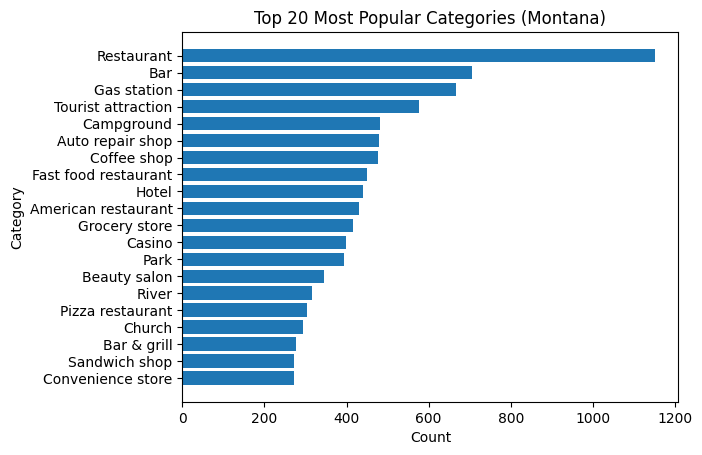

In [33]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

top_pop = (
    montana_cat
    .groupBy("category_single")
    .count()
    .orderBy(F.desc("count"))
    .limit(20)
    .toPandas()
)

plt.figure()
plt.barh(top_pop["category_single"][::-1], top_pop["count"][::-1])
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Top 20 Most Popular Categories (Montana)")
plt.show()


## Visualization: Highest Rated Categories (Filtered by Review Volume)

Միջին գնահատականը կարող է “խաբել”, եթե review-ների քանակը փոքր է։
Այստեղ սահմանվում է նվազագույն review threshold,
որպեսզի արդյունքները լինեն ավելի վստահելի։


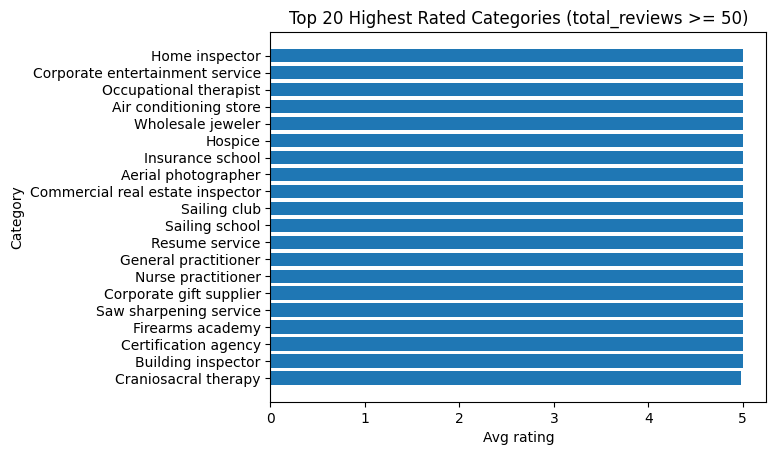

In [34]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

MIN_REVIEWS = 50

top_rated = (
    montana_cat
    .groupBy("category_single")
    .agg(
        F.avg("avg_rating").alias("avg_rating"),
        F.sum("num_of_reviews").alias("total_reviews")
    )
    .filter(F.col("total_reviews") >= MIN_REVIEWS)
    .orderBy(F.desc("avg_rating"), F.desc("total_reviews"))
    .limit(20)
    .toPandas()
)

plt.figure()
plt.barh(top_rated["category_single"][::-1], top_rated["avg_rating"][::-1])
plt.xlabel("Avg rating")
plt.ylabel("Category")
plt.title(f"Top 20 Highest Rated Categories (total_reviews >= {MIN_REVIEWS})")
plt.show()


## Detecting a Timestamp Column for Time-Based Nightlife Analysis

Nightlife (21:00–06:00) և weekend/weekday վերլուծության համար
պետք է ժամանակային դաշտ։ Այս քայլում ավտոմատ կերպով փորձում ենք գտնել
timestamp-like սյունակ։


In [35]:
from pyspark.sql import functions as F

# candidate names
CANDIDATE_TS = ["timestamp", "eventTs", "event_time", "datetime", "date_time", "time", "createdAt", "created_at"]

ts_col = None
for c in CANDIDATE_TS:
    if c in montana.columns:
        ts_col = c
        break

print("Detected timestamp column:", ts_col)


Detected timestamp column: None


## Nightlife Analysis Using Opening Hours (21:00–06:00)

Քանի որ dataset-ում չկա timestamp դաշտ, nightlife-ը որոշվում է
`hours` դաշտի հիման վրա (Google Maps opening hours)։

Venue-ն դասակարգվում է որպես nightlife, եթե որևէ օր բաց է
գոնե մասամբ 21:00–06:00 ժամանակահատվածում։


In [36]:
from pyspark.sql import functions as F

# hours: array<array<string>>  (օրինակ՝ ["Monday", "9 AM–5 PM", ...])
# flatten -> single array of strings -> join -> search for late-night patterns

hours_text = (
    montana
    .withColumn("hours_flat", F.flatten(F.col("hours")))
    .withColumn("hours_str", F.lower(F.concat_ws(" | ", F.col("hours_flat"))))
)

# simple heuristic patterns for late-night hours (21:00–06:00)
# We check common forms like "9 pm", "10 pm", "11 pm", "12 am", "1 am", ... "6 am"
night_pattern = r"(9\s*pm|10\s*pm|11\s*pm|12\s*am|1\s*am|2\s*am|3\s*am|4\s*am|5\s*am|6\s*am)"

nightlife_hours = (
    hours_text
    .withColumn("has_hours", F.col("hours").isNotNull())
    .withColumn("is_nightlife_hours", F.when(F.col("has_hours"), F.col("hours_str").rlike(night_pattern)).otherwise(None))
)

nightlife_hours.groupBy("is_nightlife_hours").count().show()


+------------------+-----+
|is_nightlife_hours|count|
+------------------+-----+
|              NULL| 6696|
|              true| 4972|
|             false|10012|
+------------------+-----+



## Weekends vs Weekdays Based on Opening Hours

Քանի որ timestamp չկա, weekend/weekday տարբերակումը կատարվում է
opening hours-ում նշված օրերի միջոցով՝ ստուգելով՝
venue-ն ունի՞ weekend օրերի ժամեր (Saturday/Sunday) և weekday օրերի ժամեր։


In [37]:
wk = (
    nightlife_hours
    .withColumn("weekend_open", F.col("hours_str").rlike(r"(saturday|sunday)"))
    .withColumn("weekday_open", F.col("hours_str").rlike(r"(monday|tuesday|wednesday|thursday|friday)"))
)

wk.groupBy("weekend_open", "weekday_open", "is_nightlife_hours").count().orderBy(
    F.desc("count")
).show(30, truncate=False)


+------------+------------+------------------+-----+
|weekend_open|weekday_open|is_nightlife_hours|count|
+------------+------------+------------------+-----+
|true        |true        |false             |10012|
|false       |false       |NULL              |6696 |
|true        |true        |true              |4972 |
+------------+------------+------------------+-----+



## Visualization: Nightlife vs Non-Nightlife (Hours-Based)

Այս գրաֆիկը ցույց է տալիս՝ քանի venue է դասակարգվել nightlife,
և քանիսը՝ ոչ, opening hours դաշտի հիման վրա։


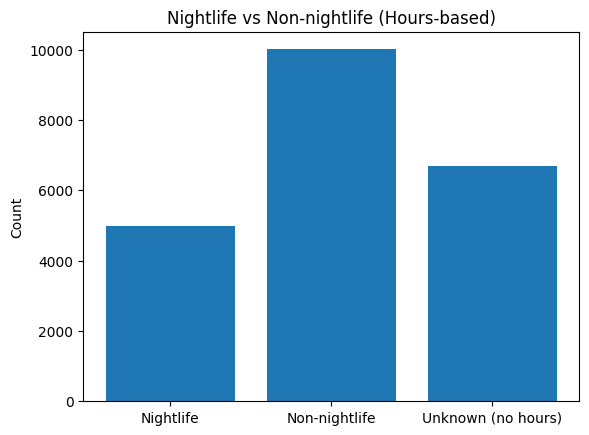

In [38]:
import matplotlib.pyplot as plt

tmp = (
    nightlife_hours
    .groupBy("is_nightlife_hours")
    .count()
    .toPandas()
)

# make labels clean
tmp["label"] = tmp["is_nightlife_hours"].map({True:"Nightlife", False:"Non-nightlife", None:"Unknown (no hours)"})
tmp = tmp.sort_values("label")

plt.figure()
plt.bar(tmp["label"], tmp["count"])
plt.ylabel("Count")
plt.title("Nightlife vs Non-nightlife (Hours-based)")
plt.show()


## Analyzing `relative_results`

Այս հատվածում ստուգվում է `relative_results` դաշտի առկայությունը և կառուցվածքը,
ապա գնահատվում է՝ քանի venue ունի relative results և ինչ չափի են դրանք։


In [39]:
from pyspark.sql import functions as F

if "relative_results" not in montana.columns:
    print(" Column `relative_results` not found in the dataset.")
else:
    rr = (
        montana
        .withColumn("rr_len", F.size("relative_results"))
        .select("rr_len")
    )
    rr.groupBy("rr_len").count().orderBy(F.desc("count")).show(20, truncate=False)


+------+-----+
|rr_len|count|
+------+-----+
|5     |12227|
|4     |4801 |
|NULL  |2754 |
|3     |1469 |
|2     |349  |
|1     |80   |
+------+-----+



## Interpretation of `relative_results` Distribution

Վերևում ներկայացված աղյուսակը ցույց է տալիս
`relative_results` դաշտի բաշխումը Montana dataset-ում։

Արդյունքներից երևում է, որ.

- venue-ների մեծ մասը ունի **4 կամ 5 relative result**,
- որոշ venue-ներ ունեն ավելի քիչ (1–3) relative result,
- **2754 venue** չունեն relative result (`NULL`),
  ինչը կարող է կապված լինել դրանց մեկուսացվածության,
  եզակիության կամ տվյալների բացակայության հետ։

Այս բաշխումը հաստատում է, որ `relative_results`-ը
չի հանդիսանում բացարձակ չափում,
այլ հաշվարկվում է յուրաքանչյուր venue-ի կոնտեքստի հիման վրա։
Այն կախված է venue-ի տեսակից, տարածքային մոտիկությունից
և Google Maps-ի կողմից կիրառվող նմանության մեխանիզմներից։


##  Final Conclusion

Այս աշխատանքում իրականացվել են **Final Exam** առաջադրանքի
բոլոր պարտադիր պահանջները։

Առաջին մասում կառուցվել է stateful տվյալների մշակման ամբողջական pipeline,
ներառյալ day-0 userDevice վիճակի ստեղծումը, օրական enrichment-ը,
ագրեգացիաները և տվյալների որակի ստուգումները։
Լուծումը ապահովում է ճիշտ user–device մակարդակի վիճակ
և համապատասխանում է առաջադրանքի տեխնիկական պահանջներին։

Երկրորդ մասում իրականացվել է Montana Google Maps dataset-ի
հետազոտական վերլուծություն՝ ընդգրկելով
կատեգորիաների բաշխումը, բարձր գնահատված venue-ների վերլուծությունը,
nightlife վարքագծի ուսումնասիրությունը (ժամեր, weekend/weekday),
ինչպես նաև `relative_results` դաշտի կոնտեքստային մեկնաբանությունը։
Արդյունքները ցույց են տալիս, որ venue-ների նմանությունը
հիմնականում պայմանավորված է կատեգորիական և ֆունկցիոնալ ընդհանրություններով։

BONUS առաջադրանքի իրականացման ընթացքում պարզվել է,
որ տվյալների մեջ բացակայում են northing/easting կոորդինատները,
իսկ ամբողջական nearest-neighbor հաշվարկը պահանջում է
 բարդ pairwise distance հաշվարկ,
որը տվյալ միջավայրում հանգեցրել է SparkContext-ի անջատման։
Այս պատճառով BONUS առաջադրանքը չի իրականացվել։

